# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [ ]:
# Instalación del paquete

# conda install pandas-datareader
# pip install pandas-datareader

In [5]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def getClose(names, start, end) :
    return yf.download(names, start=start, end=end) ["Adj Close"]

In [18]:
data_appl= getClose("AAPL", "2016-01-01", "2016-12-31" )
data_appl

[*********************100%***********************]  1 of 1 completed


Date
2016-01-04    24.074741
2016-01-05    23.471441
2016-01-06    23.012114
2016-01-07    22.040897
2016-01-08    22.157448
                ...    
2016-12-23    27.219761
2016-12-27    27.392633
2016-12-28    27.275827
2016-12-29    27.268818
2016-12-30    27.056234
Name: Adj Close, Length: 252, dtype: float64

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

<AxesSubplot:ylabel='Frequency'>

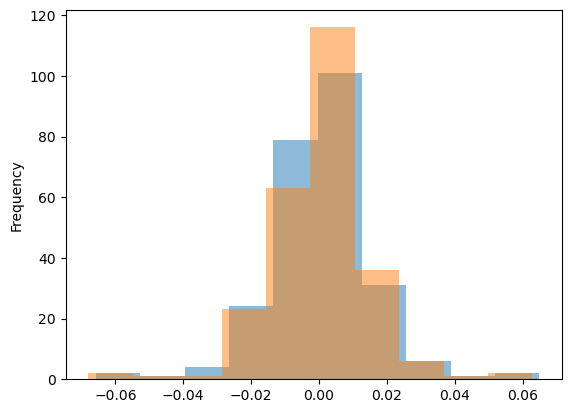

In [20]:
R= (data_appl - data_appl.shift())/data_appl.shift()
r = np.log(data_appl/data_appl.shift())
R.plot.hist(alpha=0.5)
r.plot.hist(alpha=0.5)

In [22]:
R.describe()

count    251.000000
mean       0.000574
std        0.014731
min       -0.065707
25%       -0.005780
50%        0.000891
75%        0.007734
max        0.064963
Name: Adj Close, dtype: float64

In [23]:
r.describe()


count    251.000000
mean       0.000465
std        0.014753
min       -0.067965
25%       -0.005797
50%        0.000890
75%        0.007705
max        0.062940
Name: Adj Close, dtype: float64

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [27]:
R_appl_mean = R.mean()
R_appl_std = R.std()

R

Date
2016-01-04         NaN
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042205
2016-01-08    0.005288
                ...   
2016-12-23    0.001978
2016-12-27    0.006351
2016-12-28   -0.004264
2016-12-29   -0.000257
2016-12-30   -0.007796
Name: Adj Close, Length: 252, dtype: float64

<AxesSubplot:ylabel='Frequency'>

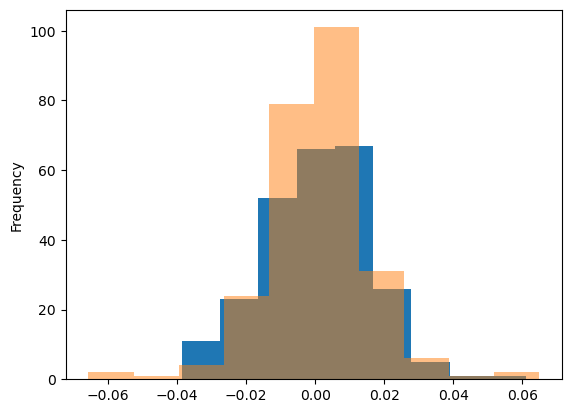

In [32]:
np.random.seed(2)
R_appl_simulados = np.random.normal(R_appl_mean, R_appl_std, size=252)
plt.figure()
plt.hist(R_appl_simulados, bins=9)
R.plot.hist(alpha =0.5, bins=10)


Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos desde 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [49]:
def sim_r(media, std, inicio, dias, N) :
    #media
    #desviacion estandar 
    #desde la fecha que inicio a simular 
    #cuantos dias voy a simular 
    #N: cuantas simulaciones 
    
    r = np.random.normal(media, std, size=(dias, N))
    fechas = pd.date_range(inicio, periods=dias)
    return pd.DataFrame(index=fechas, data=r)


r_simulados= sim_r(R_appl_mean, R_appl_std, "2016-12-31", 31 , 100)

<AxesSubplot:>

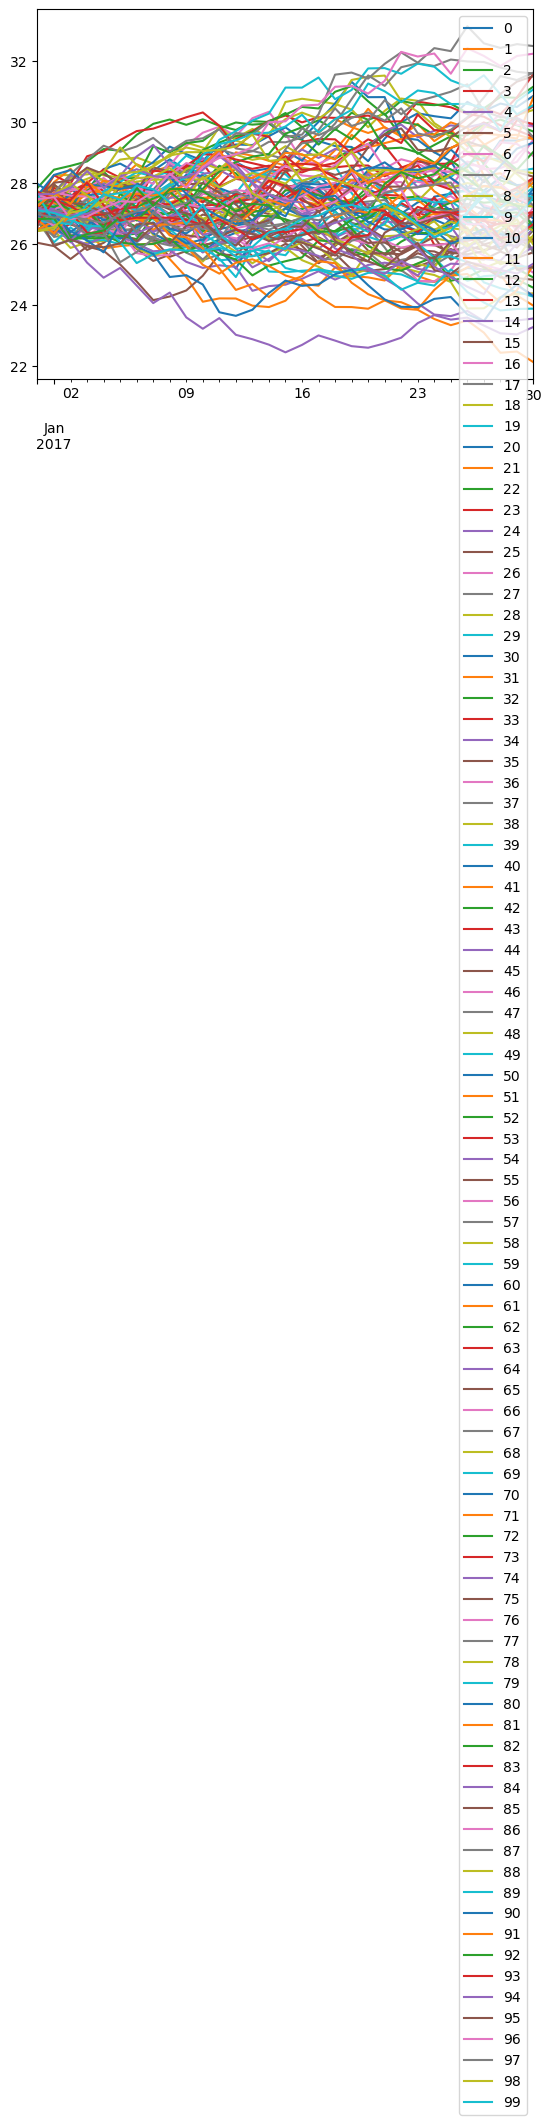

In [50]:
precios_simulados = (r_simulados + 1).cumprod()*data_appl[-1]
precios_simulados.plot()

In [51]:
pd.date_range(start="2023-01-01", periods=100)

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05',
               '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13',
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17',
               '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21',
               '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25',
      

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

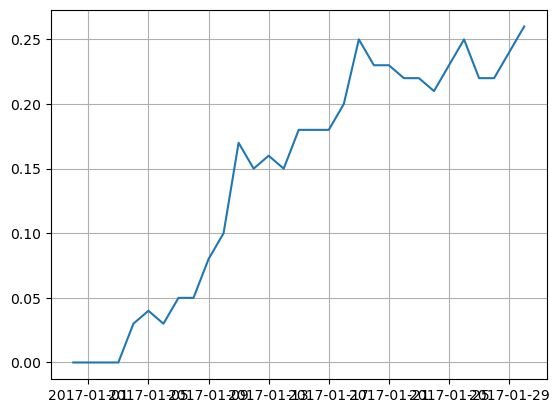

In [55]:
valor_deseado = data_appl[-1]*1.07
probabilidad= (precios_simulados >= valor_deseado).mean(axis=1)
plt.figure()
plt.plot(probabilidad)
plt.grid()



___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.